In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)

In [297]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder

In [298]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
#from catboost import CatBoostClassifier

In [299]:
df = pd.read_csv('../data/raw/Visadataset.csv')
df.shape

(25480, 12)

##### Data Cleaning
1. Handling missing/na values
2. Handling duplicate values

In [300]:
features_with_na = [col for col in df.columns if df[col].isnull().sum() >=1]
for col in df.columns:
    print(col, np.round(df[col].isnull().mean()*100, 2),'% missing values')

case_id 0.0 % missing values
continent 0.0 % missing values
education_of_employee 0.0 % missing values
has_job_experience 0.0 % missing values
requires_job_training 0.0 % missing values
no_of_employees 0.0 % missing values
yr_of_estab 0.0 % missing values
region_of_employment 0.0 % missing values
prevailing_wage 0.0 % missing values
unit_of_wage 0.0 % missing values
full_time_position 0.0 % missing values
case_status 0.0 % missing values


In [301]:
df.duplicated().sum()

np.int64(0)

##### Observations:
1. Dataset contains no null/na and duplicate records.

In [302]:
df.drop(columns=['case_id'], inplace=True)

##### Feature Engineering

In [303]:
df.sample(5)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
16069,Asia,Master's,Y,N,2780,1979,South,71322.6000,Year,Y,Certified
18395,Asia,Bachelor's,Y,N,2160,1999,West,112116.9800,Year,Y,Denied
24935,Asia,High School,N,N,491,1987,Midwest,60320.9900,Year,Y,Certified
25,North America,Master's,N,N,1100,1997,Midwest,99489.6500,Year,Y,Certified
18936,North America,Master's,N,N,2974,1976,South,255.9271,Hour,Y,Denied


In [304]:
# We will use age of the companies instead of using year of their establishment
from datetime import date
current_date = date.today()
current_year = current_date.year
current_year

2024

In [305]:
df['company_age'] = current_year - df['yr_of_estab']

In [306]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,17
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,22
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,16
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,127
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,19


In [307]:
df.drop('yr_of_estab', inplace=True, axis=1)

In [308]:
numeric_features = [col for col in df.columns if df[col].dtype != 'object']
numeric_features

['no_of_employees', 'prevailing_wage', 'company_age']

In [309]:
categorical_features = [col for col in df.columns if df[col].dtype == 'object']
categorical_features

['continent',
 'education_of_employee',
 'has_job_experience',
 'requires_job_training',
 'region_of_employment',
 'unit_of_wage',
 'full_time_position',
 'case_status']

In [310]:
discrete_features = [col for col in numeric_features if len(df[col].unique()) <=25]
discrete_features

[]

In [311]:
continuous_features = [col for col in numeric_features if len(df[col].unique()) >25]
continuous_features

['no_of_employees', 'prevailing_wage', 'company_age']

In [312]:
X = df.drop('case_status', axis=1)
y = df['case_status']

##### Feature Transformation

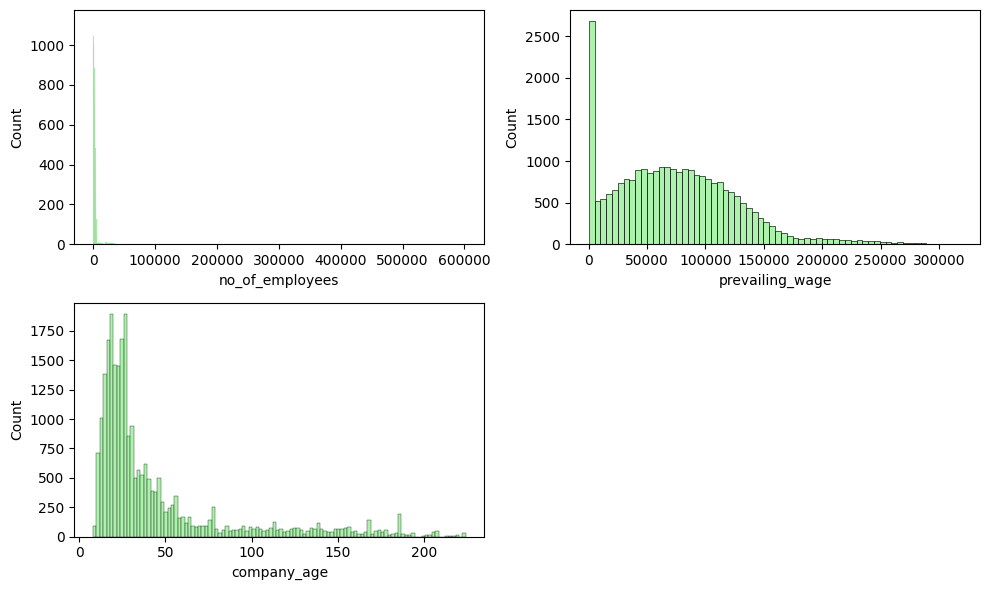

In [313]:
# distribution of data for numerical features before scaling
plt.figure(figsize=(10,6))
for i,col in enumerate(continuous_features,1):
    plt.subplot(2,2,i)
    sns.histplot(x=X[col], color='lightgreen')
    plt.xlabel(col)
    plt.tight_layout()

In [314]:
X[continuous_features].skew(axis=0, skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

##### We can see that `no_of_employees` and `company_age` are positively skewed with outliers, so we will use power transformer to handle them also to make distribution near to normal/gaussian like.

In [315]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
X_transf = pt.fit_transform(X[['no_of_employees','company_age']])
X_transf = pd.DataFrame(X_transf, columns=['no_of_employees','company_age'])

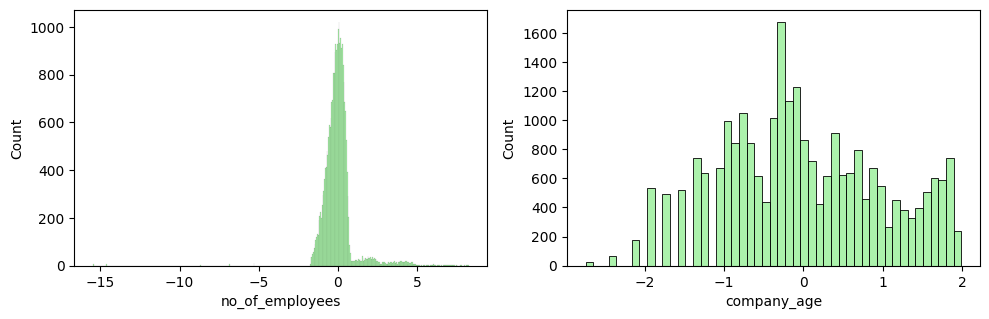

In [316]:
# distribution of data for numerical features after transformation
plt.figure(figsize=(10,6))
for i,col in enumerate(X_transf.columns,1):
    plt.subplot(2,2,i)
    sns.histplot(x=X_transf[col], color='lightgreen')
    plt.xlabel(col)
    plt.tight_layout()

In [317]:
X_transf.skew(axis=0, skipna=True)

no_of_employees    0.399339
company_age        0.103264
dtype: float64

##### After using the yeo-johnson transformation the skeweness has reduced.

In [318]:
for col in categorical_features:
    print(col, df[col].nunique())

continent 6
education_of_employee 4
has_job_experience 2
requires_job_training 2
region_of_employment 5
unit_of_wage 4
full_time_position 2
case_status 2


In [319]:
models = {
        "Random Forest": RandomForestClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "Logistic Regression": LogisticRegression(),
        "K-Neighbors Classifier": KNeighborsClassifier(),
        "XGBClassifier": XGBClassifier(),
        "Support Vector Classifier": SVC(),
        "AdaBoost Classifier": AdaBoostClassifier()
    }

In [320]:
def preprocess_data(X_train, X_test):
    or_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
    oh_columns = ['continent','unit_of_wage','region_of_employment']
    transform_columns= ['no_of_employees','company_age']
    
    power_transfrom = Pipeline(steps = [
                        ('transform', PowerTransformer(method='yeo-johnson'))
                    ])

    preprocessor = ColumnTransformer([
                        ('OneHotEncoder', OneHotEncoder(), oh_columns),
                        ('OrdinalEnconder', OrdinalEncoder(), or_columns),
                        ('Transformer', power_transfrom, transform_columns),
                        ('StandardScaler', StandardScaler(), numeric_features)
                    ])
    
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
        
    return X_train, X_test

In [321]:
# Synthetic data generation for minority class only on train dataset
def data_resample(X_train, y_train):
    smote = SMOTEENN(random_state=42, sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    return X_train, y_train

In [322]:
def evaluate_model(actual, predicted):
    acc = accuracy_score(actual, predicted)
    f1 = f1_score(actual, predicted)
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    roc_auc = roc_auc_score(actual, predicted)
    
    return acc, f1, precision, recall, roc_auc

In [323]:
def get_data(df):
    
    X = df.drop('case_status', axis=1)
    y = df['case_status']
    
    le = LabelEncoder()
    y_new = le.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.2, random_state=42)
    X_train_processed, X_test_processed = preprocess_data(X_train, X_test)
    X_train_sampled, y_train_sampled = data_resample(X_train_processed, y_train)
    
    return X_train_sampled, y_train_sampled, X_test_processed, y_test

In [324]:
def train_model(df, models):
    
    X_train_sampled, y_train_sampled, X_test_processed, y_test = get_data(df)
        
    trained_models = []
    accuracies = []
    auc = []
    
    for name, model in models.items():
        model.fit(X_train_sampled, y_train_sampled)
 
        y_train_pred = model.predict(X_train_sampled)
        y_test_pred = model.predict(X_test_processed)
        
        # Training data performance
        train_acc, train_f1, train_precision, train_recall, train_roc_auc = evaluate_model(y_train_sampled, y_train_pred)
        
        # Testing data performance
        test_acc, test_f1, test_precision, test_recall, test_roc_auc = evaluate_model(y_test, y_test_pred)
        
        trained_models.append(name)
        print(name)
        print('Model performance on training set')
        print('- Accuracy: {:.4f}'.format(train_acc))
        print('- F1 Score: {:.4f}'.format(train_f1))
        print('- Precision: {:.4f}'.format(train_precision))
        print('- Recall: {:.4f}'.format(train_recall))
        print('- ROC AUC Score: {:.4f}'.format(train_roc_auc))
        
        print('------------------------------------------------')
        
        print('Model performance on testing set')
        print('- Accuracy: {:.4f}'.format(test_acc))
        print('- F1 Score: {:.4f}'.format(test_f1))
        print('- Precision: {:.4f}'.format(test_precision))
        print('- Recall: {:.4f}'.format(test_recall))
        print('- ROC AUC Score: {:.4f}'.format(test_roc_auc))
        
        accuracies.append(test_acc)
        auc.append(test_roc_auc)
        print("\n")
        
    final_report = pd.DataFrame(zip(trained_models, accuracies, auc), columns=['Model Name', 'Accuracy', 'ROC AUC Score']).sort_values(by='Accuracy', ascending=False)
    
    return final_report

In [325]:
base_model_report = train_model(df, models)

Random Forest
Model performance on training set
- Accuracy: 1.0000
- F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
------------------------------------------------
Model performance on testing set
- Accuracy: 0.7070
- F1 Score: 0.6062
- Precision: 0.5482
- Recall: 0.6779
- ROC AUC Score: 0.6997


Decision Tree
Model performance on training set
- Accuracy: 1.0000
- F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
------------------------------------------------
Model performance on testing set
- Accuracy: 0.6915
- F1 Score: 0.5898
- Precision: 0.5288
- Recall: 0.6667
- ROC AUC Score: 0.6853


Gradient Boosting
Model performance on training set
- Accuracy: 0.8913
- F1 Score: 0.8988
- Precision: 0.9002
- Recall: 0.8975
- ROC AUC Score: 0.8908
------------------------------------------------
Model performance on testing set
- Accuracy: 0.7072
- F1 Score: 0.6274
- Precision: 0.5440
- Recall: 0.7410
- ROC AUC Score: 0.7157


Logist

In [326]:
base_model_report

,Model Name,Accuracy,ROC AUC Score
5,XGBClassifier,0.712716,0.704126
2,Gradient Boosting,0.707221,0.715694
0,Random Forest,0.707025,0.699714
1,Decision Tree,0.691523,0.685289
6,Support Vector Classifier,0.689560,0.694916
7,AdaBoost Classifier,0.687794,0.699956
4,K-Neighbors Classifier,0.664443,0.673435
3,Logistic Regression,0.605769,0.626518


##### Finding the best params for top 3 models.

In [327]:
# Hyperparamter tuning for first 3 best models
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

gradient_params = {
    "max_depth": [10, 12, None, 15, 20],
    "n_estimators": [10, 50, 100, 200]
}

In [328]:
random_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ('RF', RandomForestClassifier(), rf_params),
    ('GradientBoost', GradientBoostingClassifier(), gradient_params)
]

In [329]:
def find_best_params(df):
    model_params = {}
    for name, model, params in random_models:
        random = RandomizedSearchCV(estimator=model, 
                                    param_distributions=params,
                                    n_iter=100,
                                    cv=3,
                                    verbose=2,
                                    n_jobs=-1)
        
        X_train_sampled, y_train_sampled, _, _ = get_data(df)
        random.fit(X_train_sampled, y_train_sampled)
        model_params[name] = random.best_params_
        
    for model_name in model_params:
        print(f'--------------Best Params for {model_name}-----------------')
        print(model_params[model_name])
        
    return model_params

In [330]:
model_params = find_best_params(df)
model_params

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.3s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.3s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.3s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.3s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.3s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.2s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.2s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.3s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.3s
[CV] END ....................max_depth=5, min_child_weight=3; total time=   0.4s
[CV] END ....................max_depth=5, min_child_weight=1; total time=   0.4s
[CV] END ....................max_depth=5, min_ch

{'XGBoost': {'min_child_weight': 1, 'max_depth': 9},
 'RF': {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None},
 'GradientBoost': {'n_estimators': 200, 'max_depth': 12}}

##### Retraining the Models with best params

In [331]:
from sklearn.metrics import roc_auc_score,roc_curve

best_models = {
    "XGBClassifier": XGBClassifier(**model_params['XGBoost'], n_jobs=-1),
    "RandomForestClassifier": RandomForestClassifier(**model_params['RF']),
    "GradientBoostingClassifier": GradientBoostingClassifier(**model_params['GradientBoost'])
}

tuned_report = train_model(df, best_models)

XGBClassifier
Model performance on training set
- Accuracy: 0.9996
- F1 Score: 0.9997
- Precision: 0.9996
- Recall: 0.9997
- ROC AUC Score: 0.9996
------------------------------------------------
Model performance on testing set
- Accuracy: 0.7078
- F1 Score: 0.6064
- Precision: 0.5493
- Recall: 0.6767
- ROC AUC Score: 0.7000


RandomForestClassifier
Model performance on training set
- Accuracy: 1.0000
- F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
------------------------------------------------
Model performance on testing set
- Accuracy: 0.7086
- F1 Score: 0.6099
- Precision: 0.5497
- Recall: 0.6850
- ROC AUC Score: 0.7027


GradientBoostingClassifier
Model performance on training set
- Accuracy: 1.0000
- F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Score: 1.0000
------------------------------------------------
Model performance on testing set
- Accuracy: 0.7090
- F1 Score: 0.6080
- Precision: 0.5508
- Recall: 0.6785
- ROC AUC Scor

In [332]:
tuned_report

,Model Name,Accuracy,ROC AUC Score
2,GradientBoostingClassifier,0.708987,0.701332
1,RandomForestClassifier,0.708595,0.702666
0,XGBClassifier,0.707810,0.700006


In [333]:
train_data, train_label, test_data, test_label = get_data(df)
best_model = RandomForestClassifier(**model_params['RF'])
best_model = best_model.fit(train_data, train_label)
y_pred = best_model.predict(test_data)
score = accuracy_score(test_label, y_pred)
cr = classification_report(test_label, y_pred)

print("Best Final Model RF")
print("Accuracy Score for the model: {:.4f}".format(score))
print(cr)

Best Final Model RF
Accuracy Score for the model: 0.7086
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      3401
           1       0.55      0.69      0.61      1695

    accuracy                           0.71      5096
   macro avg       0.69      0.70      0.69      5096
weighted avg       0.73      0.71      0.72      5096



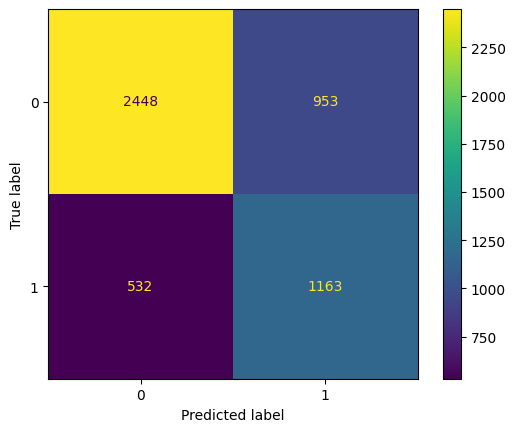

In [334]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, test_data, test_label)